# **Cookie cats game: A/B testing of user engagement and retention**
---
This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, they were randomly assigned to either `gate_30` or `gate_40`.

## **Aims**
- To investigate whether the placement of the progression gate significantly affects players' retention and engagement in the first 14 days after installation. 

## **Dataset description**
| Variable         | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `userid`           | A unique number that identifies each player                                  |
| `version`          | AB-test group assignment: `gate_30` (gate at level 30) or `gate_40` (gate at level 40) |
| `sum_gamerounds`   | Number of game rounds played during the first 14 days after install          |
| `retention_1`      | Whether the player returned and played 1 day after installing (binary)      |
| `retention_7`      | Whether the player returned and played 7 days after installing (binary)      |

## **Specific objectives**
- Does gate placement affect the total number of game rounds played in the first 14 days?
- Does gate placement affect the retention rate in the first day?
- Does gate placement affect the retention rate in the first week?

## **Key Metrics** 
- `sum of game rounds` 
- `retention_1` 
- `retention_7` 


## **Key Insights**

- Earlier progression gating (Level 30) supports stronger early retention without sacrificing engagement.
- Delaying the gate to Level 40 does not meaningfully increase engagement, but introduces additional early friction and drop-off.
- Overall, the trade-off associated with later gating appears unfavourable from a player experience and retention perspective.


## **Analysis plan**
- Data cleaning and preprocessing 
   - missing value check
   - sample size, sample distribution, sample ratio mismatch (SRM) check 
- Descriptive analysis 
   - descriptive data and distribution plot of `sum_gamerounds`
   - descriptive data and box plot on rentention after 1 day 
   - descriptive data and box plot on rentention after 1 day 
- Hypothesis testing 
   - t-test or Mann-Whitney U test to compare sum_gamerounds between two groups
   - two-proportion z test to compare `retention_1` and `retention_7` rate between two groups

In [137]:
import pandas as pd
from scipy.stats import chisquare
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
cookie_cat = pd.read_csv('C:/Users/08042/Desktop/projects/ab testing/cookie cats/cookie_cats.csv')
cookie_cat

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [160]:
cookie_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 1. EDA 

### 1.1 Descriptive data on sum of game rounds

In [110]:
cookie_cat.isna().sum()
print(cookie_cat['sum_gamerounds'].agg(['mean','median','std']))
print(cookie_cat.groupby('version')['sum_gamerounds'].agg(['max','mean','median','std']))


mean       51.872457
median     16.000000
std       195.050858
Name: sum_gamerounds, dtype: float64
           max       mean  median         std
version                                      
gate_30  49854  52.456264    17.0  256.716423
gate_40   2640  51.298776    16.0  103.294416


- The descriptive data of sum of game rounds suggested that the variable is likely **not to be normally distributed** and **highly right-skewed**, given that the median is 16 and the mean is 51.87. Further examination of the data distribution is required. 

- The standard deviation for gate 30 is 256.72, and for gate 40 is 103.29, suggesting that the players in both groups had very high variability in the sum of game rounds played. 

- The maximum value for gate 30 is 49854, which explains the extremely high variability within the data, and it's most likely an outlier.


### 1.2 Distribution of sum of game rounds 

In [69]:
df_30 = cookie_cat[cookie_cat['version']=='gate_30'].copy().reset_index(drop=True)
df_40 = cookie_cat[cookie_cat['version']=='gate_40'].copy().reset_index(drop=True)

In [73]:
df_40

,userid,version,sum_gamerounds,retention_1,retention_7
0,377,gate_40,165,True,False
1,483,gate_40,1,False,False
2,488,gate_40,179,True,True
3,540,gate_40,187,True,True
4,1444,gate_40,2,False,False
...,...,...,...,...,...
45484,9998733,gate_40,10,True,False
45485,9999441,gate_40,97,True,False
45486,9999479,gate_40,30,False,False
45487,9999768,gate_40,51,True,False


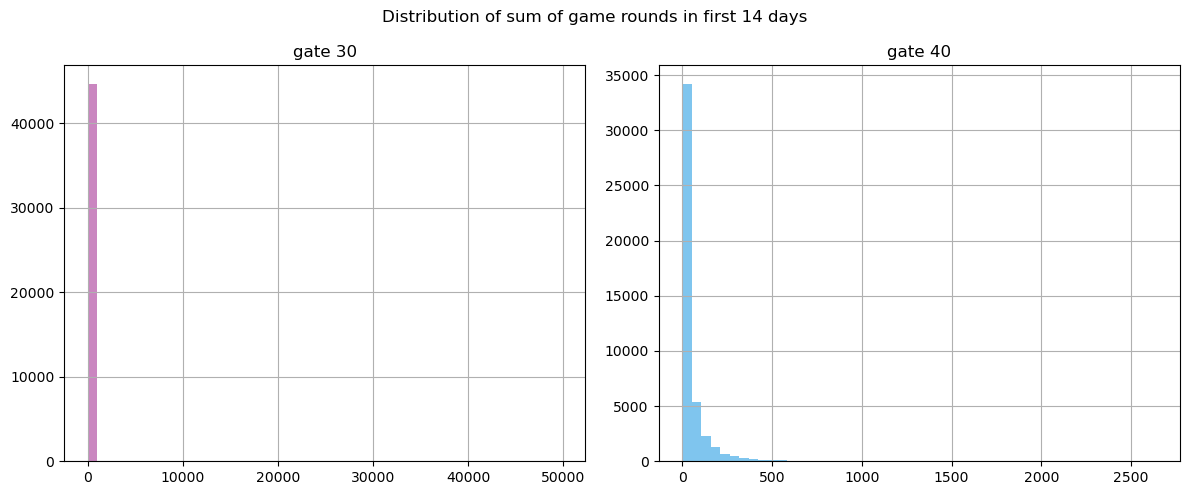

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_30['sum_gamerounds'].hist(bins=50, ax=axes[0], color='#ca86c0')
ax=axes[0].set_title('gate 30')

df_40['sum_gamerounds'].hist(bins=50, ax=axes[1], color='#7fc5ee')
ax=axes[1].set_title('gate 40')

plt.suptitle('Distribution of sum of game rounds in first 14 days')
plt.tight_layout()
plt.show()

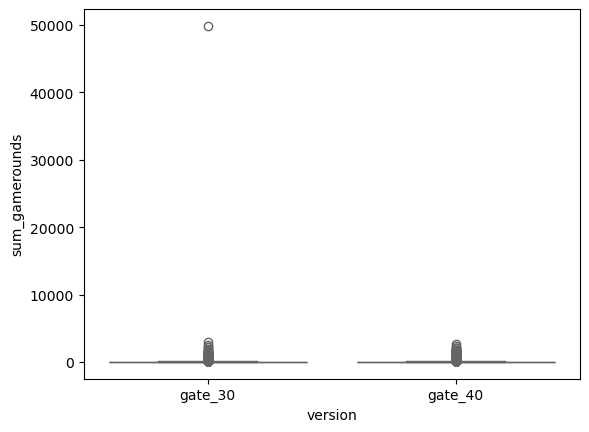

In [103]:
sns.boxplot(x='version',
            y='sum_gamerounds',
            data=cookie_cat,
            hue='version',
            palette=['#ca86c0', '#7fc5ee'])
plt.show()

As expected, the data in gate 30 contains outliers. Removal of outlier is required for further hypthesis testing analysis.

### 1.3 Removing outliers

In [92]:
def outlier_remove(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df_cleaned = df[(df[col] >= lower) & (df[col] <= upper)]
    return df_cleaned

In [93]:
cookiecat_cleaned = outlier_remove(cookie_cat,'sum_gamerounds')

### 1.4 Distribution of sum of game rounds (outlier removed)

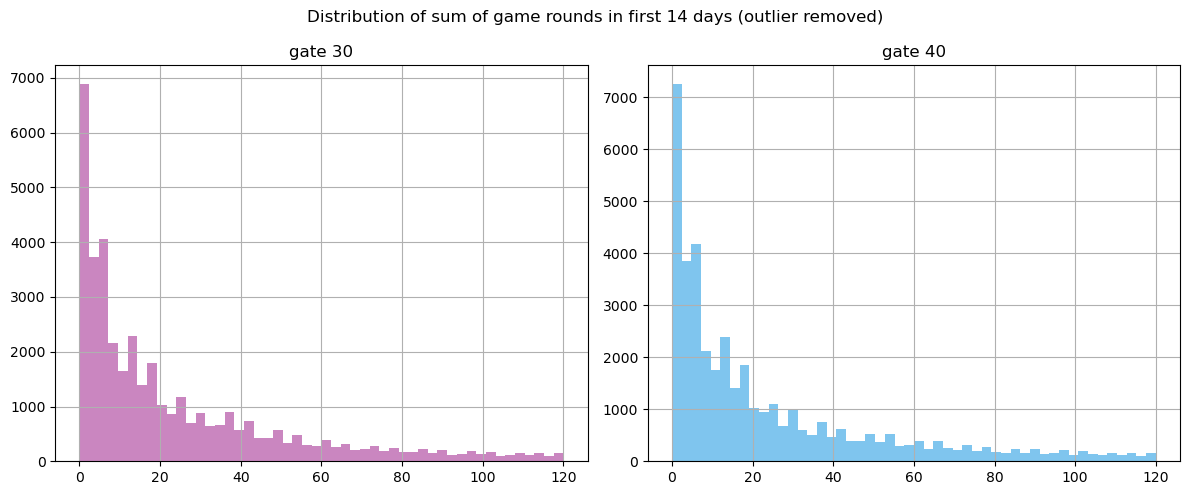

In [121]:
df_30_clean = cookiecat_cleaned[cookiecat_cleaned['version']=='gate_30'].copy().reset_index(drop=True)
df_40_clean = cookiecat_cleaned[cookiecat_cleaned['version']=='gate_40'].copy().reset_index(drop=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_30_clean['sum_gamerounds'].hist(bins=50, ax=axes[0], color='#ca86c0')
ax=axes[0].set_title('gate 30')

df_40_clean['sum_gamerounds'].hist(bins=50, ax=axes[1], color='#7fc5ee')
ax=axes[1].set_title('gate 40')

plt.suptitle('Distribution of sum of game rounds in first 14 days (outlier removed)')
plt.tight_layout()
plt.show()

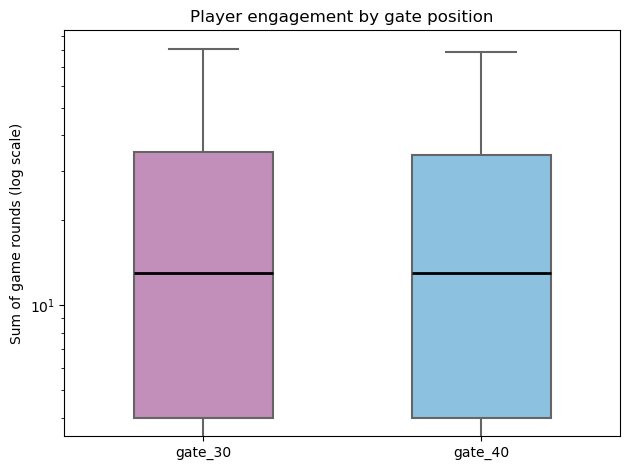

In [122]:
sns.boxplot(x='version',
            y='sum_gamerounds',
            data=cookiecat_cleaned,
            hue='version',
            palette=['#ca86c0', '#7fc5ee'],
            showfliers=False,
            width=0.5,
            linewidth=1.5,
            medianprops={'color': 'black', 'linewidth': 2}
            )

plt.yscale('log')  
plt.ylabel('Sum of game rounds (log scale)')
plt.xlabel('')
plt.title('Player engagement by gate position')

plt.tight_layout()
plt.show()

C:\Users\08042\AppData\Local\Temp\ipykernel_35652\2913410449.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


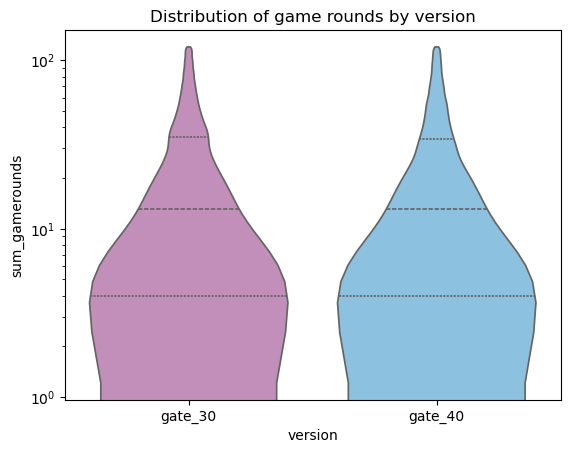

In [123]:
sns.violinplot(
    data=cookiecat_cleaned,
    x='version',
    y='sum_gamerounds',
    inner='quartile',
    palette=['#ca86c0', '#7fc5ee'],
    cut=0
)
plt.yscale('log')
plt.title('Distribution of game rounds by version')
plt.show()


## 2. Descriptive Analysis 

### 2.1 Number of users for each sum of total game rounds played

In [124]:
# number of users for each sum of total game rounds played
df_30_dist = df_30_clean.groupby('sum_gamerounds')['userid'].count()
df_40_dist = df_40_clean.groupby('sum_gamerounds')['userid'].count()

df_gate_description = pd.concat([df_30_dist.describe(percentiles=[0.25, 0.5, 0.75,0.95]), df_40_dist.describe(percentiles=[0.25, 0.5, 0.75,0.95])], axis=1)
df_gate_description.columns = ['gate_30', 'gate_40']
df_gate_description

,gate_30,gate_40
count,121.000000,121.000000
mean,327.586777,333.669421
std,474.217508,492.934789
min,41.000000,45.000000
25%,73.000000,78.000000
50%,135.000000,150.000000
75%,328.000000,324.000000
95%,1420.000000,1441.000000
max,2749.000000,2789.000000


Text(0.5, 0, 'Sum of Total Game Rounds')

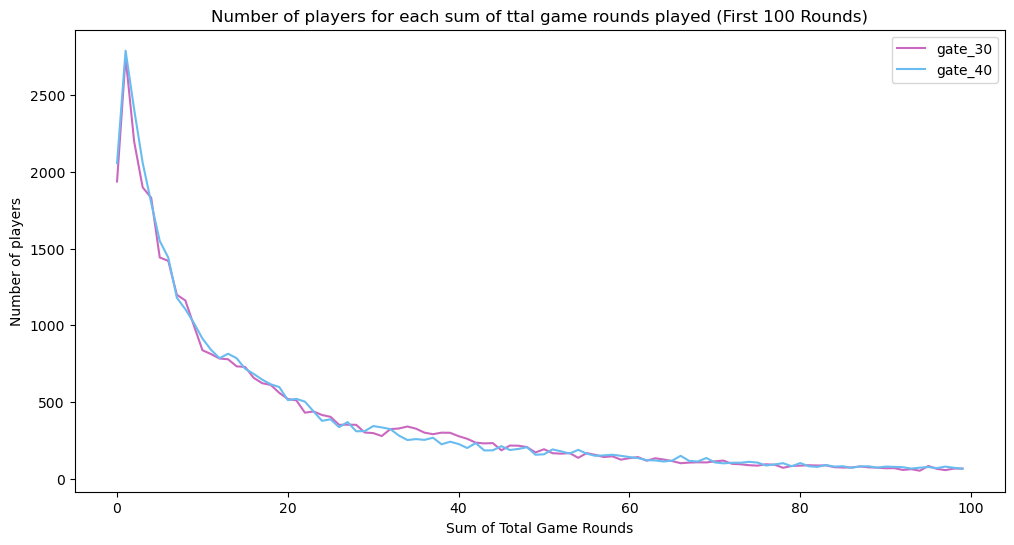

In [125]:
plt.figure(figsize=(12,6))
df_30_dist.head(100).plot(label='gate_30', legend=True, color='#ca68c0')
df_40_dist.head(100).plot(label='gate_40', legend=True, color='#69bcef')
plt.title('Number of players for each sum of ttal game rounds played (First 100 Rounds)')
plt.ylabel('Number of players')
plt.xlabel('Sum of Total Game Rounds')

### 2.2 Sum of game rounds by gate placement (outlier removed)

In [126]:
cookiecat_cleaned.groupby('version')['sum_gamerounds'].agg(['max','mean','median','std','count'])

,max,mean,median,std,count
version,,,,,
gate_30,120,23.945179,13.0,27.152547,39638
gate_40,120,24.012558,13.0,27.800704,40374


### 2.3 Retention rate by gate placement

In [127]:
cookiecat_cleaned.groupby('version').agg({'retention_1':'mean', 'retention_7':'mean'})

,retention_1,retention_7
version,,
gate_30,0.389096,0.118119
gate_40,0.383366,0.109798


The retention rate for gate 30 and gate 40 placement are around 38% and 39% after 1 day, and around 11% and 12% after 7 days, respectively. Statistic tests are needed to determine whether the difference is significant. 

### 2.4 Sum of game rounds by retention type and gate placement 

In [115]:
cookiecat_cleaned.groupby(['version','retention_1'])['sum_gamerounds'].agg(['max','mean','median','std','count'])

max       mean  median        std  count
version retention_1                                          
gate_30 False        120  12.642660     6.0  17.491398  24215
        True         120  41.690786    35.0  29.983310  15423
gate_40 False        120  12.655165     6.0  17.972346  24896
        True         120  42.280656    34.0  30.908286  15478

In [116]:
cookiecat_cleaned.groupby(['version','retention_7'])['sum_gamerounds'].agg(['max','mean','median','std','count'])

max       mean  median        std  count
version retention_7                                          
gate_30 False        120  19.681113    11.0  23.304905  34956
        True         120  55.780863    53.0  32.212640   4682
gate_40 False        120  19.889541    10.0  23.958521  35941
        True         120  57.440334    55.0  33.618387   4433

Similarly, the total games played by users rentended after 1 day and 7 days showed comparable results for both groups. Statistic tests will be used to examine whether the differences are statistically significant. 

## 3. A/B testing 

1. Sample Ratio Mismatch (SRM) check 
2. Setting hypothesis 
2. Determine the distribution of metrics and recommended test per metric 
3. Normality check 
4. Perform tests and interpret results

### 3.1 SRM check 
- _H0_: The group allocation matches the experiment design which is 50/50. 
- alpha = .01
- if p < alpha, reject _H0_, and there is a sample ratio mismatch.
- if p > alpha, fail to reject _H0_, and there is no sample ratio mismatch.

In [134]:
observed = cookiecat_cleaned['version'].value_counts().sort_index().values
expected = [observed.sum() / 2] * 2

statistic, pvalue = chisquare(observed, expected)
statistic, pvalue

alpha = 0.01  

print(f'SRM chi-square p-value: {pvalue:.4f}')

if pvalue >= alpha:
    print('Randomization check passed (no SRM detected).')
else:
    print('Statistically significant SRM detected.')
    print('Check absolute allocation difference before taking action.')

SRM chi-square p-value: 0.0093
Statistically significant SRM detected.
Check absolute allocation difference before taking action.


In [131]:
counts = cookiecat_cleaned['version'].value_counts()
proportions = counts / counts.sum()
counts, proportions


(version
 gate_40    40374
 gate_30    39638
 Name: count, dtype: int64,
 version
 gate_40    0.504599
 gate_30    0.495401
 Name: count, dtype: float64)

Although the chi-square SRM check showed a statistically significant deviation from the expected 50/50 split of sample (p=0.0093), the absolute allocation difference was less than 1%, indicating that the sample allocation was well-balanced and I can proceed with the analysis.

### 3.2 Setting hypothesis 
- _H0_: There is no difference between two groups (`gate_30` and `gate_40`).
- _H1_: There is a significant difference between two groups.

- alpha = 0.05 
- If p-value < alpha: reject _H0_ (There is a significant difference between 2 groups)
- If p-value > alpha: fail to reject _H0_ (There is no significant difference between 2 groups)

### 3.3 Distribution of metrics and recommended tests

| Metric          | Type                         | Distribution assumption | Recommended test |
|-----------------|------------------------------|--------------------------|------------------|
| `sum_gamerounds`  | Count / continuous, right-skewed   | Non-normal               | Mann–Whitney U |
| `retention_1`     | Binary                       | Bernoulli                | Two-proportion z-test |
| `retention_7`     | Binary                       | Bernoulli                | Two-proportion z-test |



### 3.4 Normaility check 
Histogram of distribution of the sum of game rounds suggested a highly right-skewed distribution and a normal distribution can not be assumed, therefore, a non-parametric test is required (Mann-Whitney U test) to examine the difference between the sum of game rounds between the two groups. 

### 3.5 Mann-Whitney U test for sum of game rounds between two gate placements

In [152]:
u_stat, u_pval = mannwhitneyu(df_30_clean['sum_gamerounds'],
                              df_40_clean['sum_gamerounds'],
                              alternative='two-sided')
print(f'Mann-Whitney U test: U = {u_stat}, p-value = {u_pval}')

if u_pval <.05: 
    print('Reject the null hypothesis, there is a significant difference in sum of game rounds played in first 14 days between the two groups.')
else: 
    print('Fail to reject the null hypothesis, there is no significant difference in sum of game rounds played in first 14 days between the two groups.')

Mann-Whitney U test: U = 806916458.0, p-value = 0.03885510150342266
Reject the null hypothesis, there is a significant difference in sum of game rounds played in first 14 days between the two groups.


In [158]:
n1, n2 = len(df_30_clean['sum_gamerounds']), len(df_40_clean['sum_gamerounds'])
r_rb = 1-(2*u_stat)/(n1*n2)

print(f'Rank-biserial correlation (r_rb) = {r_rb:.3f}')

cle = (1 + r_rb) / 2
print(
    f'This corresponds to a {cle:.1%} probability that a randomly selected '
    f'Gate 40 user played more games than a Gate 30 user.'
)


Rank-biserial correlation (r_rb) = -0.008
This corresponds to a 49.6% probability that a randomly selected Gate 40 user played more games than a Gate 30 user.


### 3.6 Two-proportion Z-test for rentention rate between two gate placements 

#### 3.6.1 Retention rate after 1 day between gate 30 and 40

In [144]:
n_30 = len(df_30_clean)
n_40 = len(df_40_clean)

retended_1_30 = df_30_clean['retention_1'].sum()
retended_1_40 = df_40_clean['retention_1'].sum()

retention_1_abtest = [retended_1_30, retended_1_40]
n_test = [n_30, n_40]

z_stat,pval = proportions_ztest(retention_1_abtest, nobs=n_test)
(df_30_lo95,df_40_lo95),(df_30_up95,df_40_up95) = proportion_confint(retention_1_abtest, nobs=n_test, alpha=0.05)

print(f'p-value: {pval:.4f}')
print(f'95% confidence interval for gate 30: [{df_30_lo95:.4f},{df_30_up95:.4f}]')
print(f'95% confidence interval for gate 40: [{df_40_lo95:.4f},{df_40_up95:.4f}]')

p-value: 0.0960
95% confidence interval for gate 30: [0.3843,0.3939]
95% confidence interval for gate 40: [0.3786,0.3881]


#### 3.6.2 Retention rate after 1 week between gate 30 and 40

In [145]:
n_30 = len(df_30_clean)
n_40 = len(df_40_clean)

retended_7_30 = df_30_clean['retention_7'].sum()
retended_7_40 = df_40_clean['retention_7'].sum()

retention_7_abtest = [retended_7_30, retended_7_40]
n_test = [n_30, n_40]

z_stat,pval = proportions_ztest(retention_7_abtest, nobs=n_test)
(df_30_lo95,df_40_lo95),(df_30_up95,df_40_up95) = proportion_confint(retention_7_abtest, nobs=n_test, alpha=0.05)

print(f'p-value: {pval:.4f}')
print(f'95% confidence interval for gate 30: [{df_30_lo95:.4f},{df_30_up95:.4f}]')
print(f'95% confidence interval for gate 40: [{df_40_lo95:.4f},{df_40_up95:.4f}]')

p-value: 0.0002
95% confidence interval for gate 30: [0.1149,0.1213]
95% confidence interval for gate 40: [0.1067,0.1128]


In [159]:
print('1-week retention:')
print('Gate 30: 11.81%')
print('Gate 40: 10.97%')
print('Risk difference (Gate 40 - Gate 30): -0.84 percentage points')


1-week retention:
Gate 30: 11.81%
Gate 40: 10.97%
Risk difference (Gate 40 − Gate 30): −0.84 percentage points


## 4. Summary 

- Mann-Whitney U test showed a significant difference in the sum of games played between the two groups, indicating that moving the gate to level 30 to level 40 significantly increased the number of games played by players. However, this difference is minimal (rank-biserial r=-0.008), corresponding to a 49.6% probability that a gate 40 user played more games than a gate 30 user. Therefore, the improve in engagement could be minimal at the individual user level. 

- Two-proportion z tested showed no significant difference in retention rate after 1 day installation between two groups but a significant difference in retention rate after 7 days installation, with gate 30 (11.81%) having higher retention rate than gate 40 (10.97%) placement. 

## 5. Recommendations 

**Keeping gate 30** is a better choice for the game, as **early retention** is always key to the long-term user value. Gate 40 does not deliver a meaningful increase in engagement and negatively impacts early retention, making the tradeoff unfavorable. 